In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, RocCurveDisplay, fbeta_score,  fbeta_score, roc_curve, auc, roc_auc_score,average_precision_score, precision_score, recall_score, f1_score, balanced_accuracy_score


sns.set_theme(style="white", font_scale=1.3) #palette=sns.husl_palette(n_colors=8)

In [14]:
'''
Edit here 
'''
perc=100
dataset = "PRESURGERY"
model = "rfc"           # "rfc", 'xgb', "log", "gpc"
target = "Conclusion_micro"

In [15]:
sel_vars = f"iterativeBoruta_{perc}perc"   
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"
PATH_res = f"{PATH}/results/30_modelComparison/{dataset}/{sel_vars}/modelComparison"
PATH_fig = f"{PATH}/figures/{dataset}/{sel_vars}"
os.makedirs(PATH_fig, exist_ok=True)

df = pd.read_csv(os.path.join(PATH_res, f"individualPredictions_modelComparison_{model}.csv"))

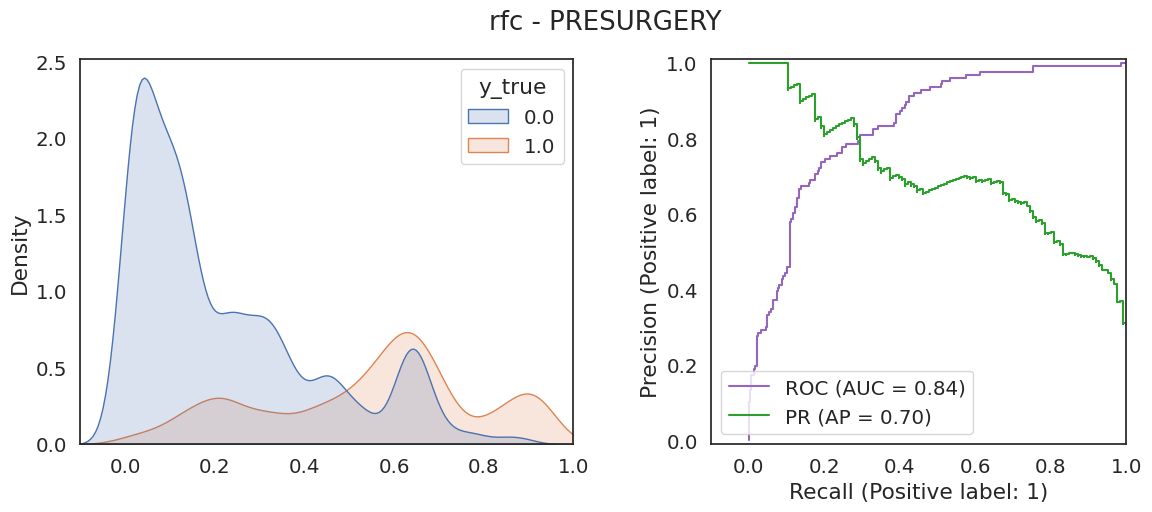

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.kdeplot(data=df, x="y_predProb", bw_adjust=0.5, hue="y_true", fill=True, common_norm=True, alpha=0.2, ax=ax1)
#sns.histplot(data=df, x="y_predProb", hue="y_true", ax=ax2)

RocCurveDisplay.from_predictions(
    df["y_true"],
    df["y_predProb"],
    name=f"ROC",
    color=sns.color_palette("tab10")[4],
    ax=ax2)

PrecisionRecallDisplay.from_predictions(df["y_true"],  
                                        df["y_predProb"], 
                                        name=f"PR",
                                        color=sns.color_palette("tab10")[2],
                                        ax=ax2)
ax1.set_xlim(-0.1,1)
ax2.set_xlim(-0.1,1)
ax1.set_xlabel("")
fig.suptitle(f"{model} - {dataset}")
fig.savefig(f"{PATH_fig}/densityDistribution.png", dpi=300)

# New threshold to minimise FN

In [17]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype(int)

In [18]:
# define thresholds to try
thresholds = np.arange(0,1,0.01)

#### F_BETA with beta=2 to minimise false negatives! ####
# get scores
scores_beta = [fbeta_score(df["y_true"], to_labels(df["y_predProb"], t), average="macro", beta=2) for t in thresholds]
# get best threshold
ix_beta = np.argmax(scores_beta)
print(f"Dataset={dataset}, Threshold={thresholds[ix_beta]}, F-score={scores_beta[ix_beta]}")

Dataset=PRESURGERY, Threshold=0.41000000000000003, F-score=0.7678315228530437


Text(0.5, 0.98, 'iterativeBoruta_100perc - rfc')

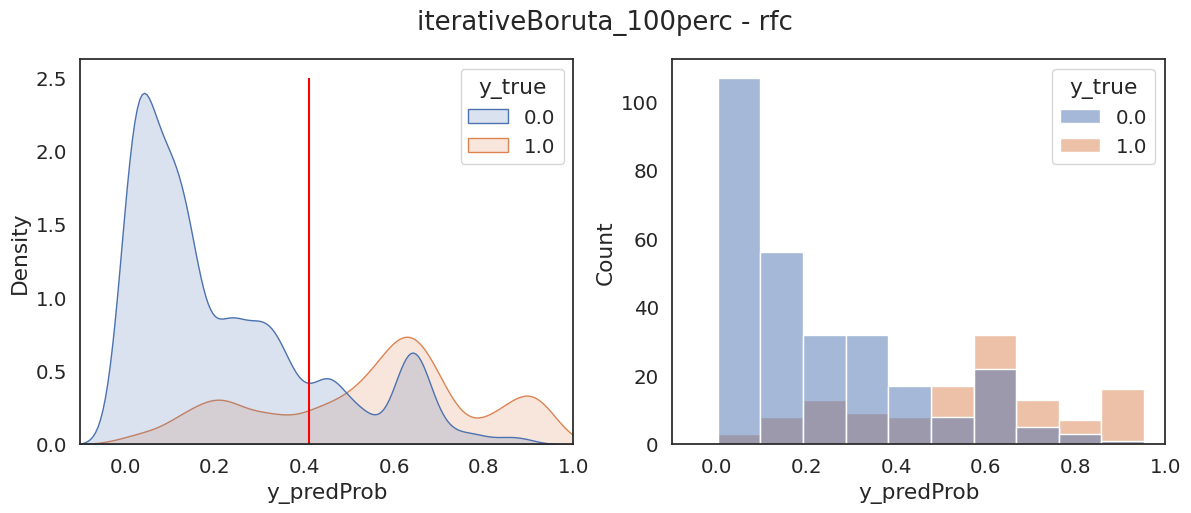

In [19]:
''' 
Explore density distributions
'''

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.kdeplot(data=df, x="y_predProb", bw_adjust=0.5, hue="y_true", fill=True, common_norm=True, alpha=0.2, ax=ax1)
sns.histplot(data=df, x="y_predProb", hue="y_true", ax=ax2)
#ax1.vlines(0.5, 0, 2.5, linestyles="dashed", color="gray")
ax1.vlines(thresholds[ix_beta], 0, 2.5, color="red")
ax1.set_xlim(-0.1,1)
ax2.set_xlim(-0.1,1)
fig.suptitle(f"{sel_vars} - {model}")

## Save the new decision threshold as new output

In [20]:
''' save new labels '''
ypred_new = to_labels(df["y_predProb"], thresholds[ix_beta])
df_new = df.drop("y_predProb", axis=1)
df_new.loc[:,"y_pred"] = ypred_new
df_new.to_csv(os.path.join(PATH_res, f"individualPredictions_modelComparison_{model}_minimiseFN.csv"))

In [21]:
''' Calculate new metrices and save '''
#["precision","recall","f1","accuracy","model","auc"]


prec = precision_score(df["y_true"], df_new["y_pred"])
rec = recall_score(df["y_true"], df_new["y_pred"])
f1 = f1_score(df["y_true"], df_new["y_pred"])
acc = balanced_accuracy_score(df["y_true"], df_new["y_pred"])
roc_auc = roc_auc_score(df["y_true"],df["y_predProb"])
precision_recall = average_precision_score(df["y_true"],df["y_predProb"])
results = {"precision": prec,
	"recall": rec,
	"f1": f1,
	"accuracy": acc,
	"model": model,
    "roc_auc":roc_auc,
    "average_prec":precision_recall
	}  
df_results_new = pd.DataFrame(pd.Series(results))
df_results_new.to_csv(os.path.join(PATH_res, f"prediction_modelComparison_{model}_minimiseFN.csv"))

df_results_new

,0
precision,0.632653
recall,0.738095
f1,0.681319
accuracy,0.773641
model,rfc
roc_auc,0.838325
average_prec,0.70372


# Calibration curve

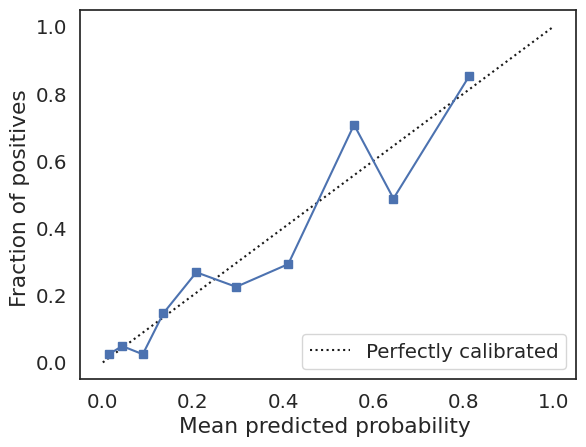

In [26]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(df["y_true"], df["y_predProb"], n_bins=10,strategy="quantile")
CalibrationDisplay(prob_true, prob_pred, df["y_predProb"]).plot()